# Imports

## pip install

In [1]:
!pip install onnxruntime onnx skl2onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.5/298.5 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from itertools import product
from google.colab import drive


from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import ttest_rel


from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import to_onnx
from skl2onnx import convert_sklearn
import onnxruntime as rt
import onnx

In [2]:
# drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
np.random.seed=42

## data & models

In [4]:
data = pd.read_csv('/content/drive/MyDrive/tnv-final-project/synth_data_translated.csv')
og_data = pd.read_csv('/content/drive/MyDrive/tnv-final-project/og_synth_data_for_training.csv')
test_data = pd.read_csv('/content/drive/MyDrive/tnv-final-project/test.csv')

In [5]:
model_1 = rt.InferenceSession('/content/drive/MyDrive/tnv-final-project/model1.onnx')
model_2 = rt.InferenceSession('/content/drive/MyDrive/tnv-final-project/model2.onnx')
model_gbc = rt.InferenceSession('/content/drive/MyDrive/tnv-final-project/gboost.onnx')

# Utils

In [6]:
def plot_confusion_matrix(cm, model_name, ax):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"Confusion Matrix: {model_name}")
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.xaxis.set_ticklabels(['False', 'True'])
    ax.yaxis.set_ticklabels(['False', 'True'])

In [7]:
def evaluate(true_values, predictions):
  accuracy = accuracy_score(true_values, predictions)
  precision = precision_score(true_values, predictions)
  recall = recall_score(true_values, predictions)
  f1 = f1_score(true_values, predictions)
  return accuracy, precision, recall, f1

# Test-Cases

In [8]:
y_test_data_from_training = test_data['checked']
X_test_data_from_training = test_data.copy(deep=True).astype(np.float32)
X_test_data_from_training.drop('checked', axis=1, inplace=True)
X_test_data_from_training

,adres_aantal_brp_adres,adres_aantal_verschillende_wijken,adres_aantal_verzendadres,adres_aantal_woonadres_handmatig,adres_dagen_op_adres,adres_recentst_onderdeel_rdam,adres_recentste_buurt_groot_ijsselmonde,adres_recentste_buurt_nieuwe_westen,adres_recentste_buurt_other,adres_recentste_buurt_oude_noorden,...,typering_dagen_som,typering_hist_aantal,typering_hist_inburgeringsbehoeftig,typering_hist_ind,typering_hist_sector_zorg,typering_ind,typering_indicatie_geheime_gegevens,typering_other,typering_transport__logistiek___tuinbouw,typering_zorg__schoonmaak___welzijn
0,5.0,4.0,1.0,1.0,2876.0,0.0,0.0,0.0,1.0,0.0,...,5368.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,3.0,2.0,1.0,1.0,3504.0,1.0,0.0,0.0,0.0,0.0,...,6183.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,3.0,1.0,0.0,0.0,5918.0,1.0,0.0,0.0,0.0,0.0,...,1617.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,2.0,1.0,1.0,11532.0,1.0,0.0,0.0,1.0,0.0,...,1427.0,3.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4,2.0,1.0,0.0,0.0,23426.0,1.0,0.0,0.0,1.0,0.0,...,-1308.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3157,3.0,2.0,0.0,0.0,5518.0,1.0,0.0,0.0,1.0,0.0,...,-2897.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3158,1.0,2.0,1.0,0.0,11521.0,1.0,1.0,0.0,0.0,0.0,...,-389.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3159,4.0,3.0,1.0,0.0,3424.0,1.0,0.0,0.0,1.0,0.0,...,1486.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3160,2.0,2.0,0.0,1.0,16151.0,1.0,0.0,0.0,0.0,0.0,...,2355.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [9]:
y_test = og_data['checked']
X_test = og_data.copy(deep=True).astype(np.float32)
X_test.drop('checked', axis=1, inplace=True)
X_test

,adres_aantal_brp_adres,adres_aantal_verschillende_wijken,adres_aantal_verzendadres,adres_aantal_woonadres_handmatig,adres_dagen_op_adres,adres_recentst_onderdeel_rdam,adres_recentste_buurt_groot_ijsselmonde,adres_recentste_buurt_nieuwe_westen,adres_recentste_buurt_other,adres_recentste_buurt_oude_noorden,...,typering_dagen_som,typering_hist_aantal,typering_hist_inburgeringsbehoeftig,typering_hist_ind,typering_hist_sector_zorg,typering_ind,typering_indicatie_geheime_gegevens,typering_other,typering_transport__logistiek___tuinbouw,typering_zorg__schoonmaak___welzijn
0,6.0,3.0,1.0,0.0,1012.0,1.0,0.0,0.0,1.0,0.0,...,917.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,2.0,1.0,0.0,5268.0,1.0,0.0,0.0,0.0,0.0,...,1603.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,4.0,2.0,0.0,1.0,1820.0,1.0,0.0,0.0,1.0,0.0,...,-4769.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,2.0,0.0,1.0,9056.0,1.0,0.0,0.0,0.0,0.0,...,4189.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3.0,3.0,0.0,2.0,5246.0,1.0,0.0,0.0,1.0,0.0,...,502.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12640,3.0,3.0,1.0,1.0,7257.0,1.0,0.0,0.0,1.0,0.0,...,194.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
12641,5.0,4.0,1.0,1.0,5618.0,1.0,0.0,0.0,1.0,0.0,...,-4052.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
12642,4.0,2.0,0.0,1.0,8409.0,1.0,0.0,0.0,0.0,0.0,...,-1858.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
12643,2.0,1.0,0.0,0.0,12242.0,1.0,0.0,0.0,0.0,0.0,...,-2023.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


# Differential Tests

In [10]:
y_pred_m1 =  model_1.run(None, {'X': X_test_data_from_training.values.astype(np.float32)})
y_pred_m1_full =  model_1.run(None, {'X': X_test.values.astype(np.float32)})

evaluation_m1 = evaluate(y_test_data_from_training, y_pred_m1[0])
evaluation_m1_full = evaluate(y_test, y_pred_m1_full[0])
print('Evaluation of m1 on test: ', evaluation_m1)
print('Evaluation of m1 on full test: ', evaluation_m1_full)

Evaluation of m1 on test:  (0.9025932953826692, 0.0, 0.0, 0.0)
Evaluation of m1 on full test:  (0.9000395413206801, 0.5454545454545454, 0.0047430830039525695, 0.009404388714733545)


In [11]:
y_pred_m2 =  model_2.run(None, {'X': X_test_data_from_training.values.astype(np.float32)})
y_pred_m2_full =  model_2.run(None, {'X': X_test.values.astype(np.float32)})

evaluation_m2 = evaluate(y_test_data_from_training, y_pred_m2[0])
evaluation_m2_full = evaluate(y_test, y_pred_m2_full[0])
print('Evaluation of m2 on test: ', evaluation_m2)
print('Evaluation of m2 on full test: ', evaluation_m2_full)

Evaluation of m2 on test:  (0.9437065148640101, 0.8809523809523809, 0.48366013071895425, 0.6244725738396624)
Evaluation of m2 on full test:  (0.9855278766310794, 0.982174688057041, 0.8711462450592885, 0.9233347297863427)


In [12]:
y_pred_m_gbc =  model_gbc.run(None, {'X': X_test_data_from_training.values.astype(np.float32)})
y_pred_m_gbc_full =  model_gbc.run(None, {'X': X_test.values.astype(np.float32)})

evaluation_m_gbc = evaluate(y_test_data_from_training, y_pred_m_gbc[0])
evaluation_full_m_gbc_full = evaluate(y_test, y_pred_m_gbc_full[0])
print('Evaluation of m_gbc on test: ', evaluation_m_gbc)
print('Evaluation of m_gbc on full test: ', evaluation_full_m_gbc_full)

Evaluation of m_gbc on test:  (0.9456040480708412, 0.7768595041322314, 0.6143790849673203, 0.6861313868613138)
Evaluation of m_gbc on full test:  (0.9527085804665876, 0.8292201382033564, 0.6640316205533597, 0.7374890254609308)


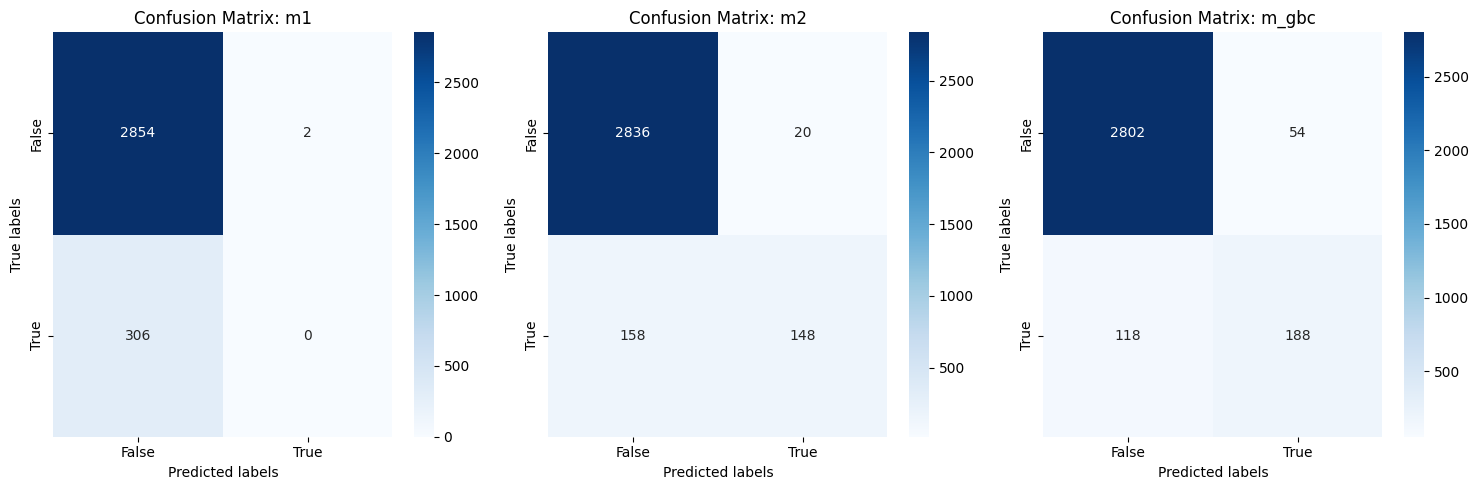

In [13]:
m1_confusion_matrix = confusion_matrix(y_test_data_from_training, y_pred_m1[0])
m2_confusion_matrix = confusion_matrix(y_test_data_from_training, y_pred_m2[0])
m_gbc_confusion_matrix = confusion_matrix(y_test_data_from_training, y_pred_m_gbc[0])


# m1_confusion_matrix = confusion_matrix(y_test, y_pred_m1_full[0])
# m2_confusion_matrix = confusion_matrix(y_test, y_pred_m2_full[0])
# m_gbc_confusion_matrix = confusion_matrix(y_test, y_pred_m_gbc_full[0])


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

plot_confusion_matrix(m1_confusion_matrix, "m1", ax[0])
plot_confusion_matrix(m2_confusion_matrix, "m2", ax[1])
plot_confusion_matrix(m_gbc_confusion_matrix, "m_gbc", ax[2])


plt.tight_layout()
plt.show()

# Metamorphic Tests

### Create Archetypes

based on the following features:
 - person_sex_woman: 0, 1
 - person_age_during_investigation: 20, 30, 40, 50, 60
 - relationship_child_current_number: 0, 1, 2, 3, 4
 - obstacles_days_financial_problems: min, 2std - mean, std - mean, mean, std + mean, 2std + mean, max
 - relationship_partner_total_days_partner: 0, 2std-mean, std-mean, mean, std+mean, 2std+mean, max

##### Compose Data

In [14]:
obstacles_days_financial_problems = []
obstacles_days_financial_problems.append(test_data['belemmering_dagen_financiele_problemen'].mean() - 2 * test_data['belemmering_dagen_financiele_problemen'].std())
obstacles_days_financial_problems.append(test_data['belemmering_dagen_financiele_problemen'].mean() - test_data['belemmering_dagen_financiele_problemen'].std())
obstacles_days_financial_problems.append(test_data['belemmering_dagen_financiele_problemen'].mean())
obstacles_days_financial_problems.append(test_data['belemmering_dagen_financiele_problemen'].mean() + 2 * test_data['belemmering_dagen_financiele_problemen'].std())
obstacles_days_financial_problems.append(test_data['belemmering_dagen_financiele_problemen'].mean() + test_data['belemmering_dagen_financiele_problemen'].std())

In [15]:
relationship_partner_total_days_partner = []
relationship_partner_total_days_partner.append(test_data['relatie_partner_totaal_dagen_partner'].mean() - 2 * test_data['relatie_partner_totaal_dagen_partner'].std())
relationship_partner_total_days_partner.append(test_data['relatie_partner_totaal_dagen_partner'].mean() - test_data['relatie_partner_totaal_dagen_partner'].std())
relationship_partner_total_days_partner.append(test_data['relatie_partner_totaal_dagen_partner'].mean())
relationship_partner_total_days_partner.append(test_data['relatie_partner_totaal_dagen_partner'].mean() + 2 * test_data['relatie_partner_totaal_dagen_partner'].std())
relationship_partner_total_days_partner.append(test_data['relatie_partner_totaal_dagen_partner'].mean() + test_data['relatie_partner_totaal_dagen_partner'].std())

In [16]:
person_sex_woman = [0, 1]
person_age_during_investigation = [20, 30, 40, 50, 60]
relationship_child_current_number = [0, 1, 2, 3, 4]

In [17]:
archetype_test = list(product(person_sex_woman, person_age_during_investigation, relationship_child_current_number, relationship_partner_total_days_partner, obstacles_days_financial_problems))
archetype_test = pd.DataFrame(archetype_test, columns=['persoon_geslacht_vrouw', 'persoon_leeftijd', 'relatie_kind_huidige_aantal', 'relatie_partner_totaal_dagen_partner', 'belemmering_dagen_financiele_problemen'])

In [18]:
mean_df = pd.DataFrame([X_test.mean()])
mean_df.drop(columns=['persoon_geslacht_vrouw', 'persoon_leeftijd_bij_onderzoek', 'relatie_kind_huidige_aantal', 'relatie_partner_totaal_dagen_partner', 'belemmering_dagen_financiele_problemen'], inplace=True)
mean_df

,adres_aantal_brp_adres,adres_aantal_verschillende_wijken,adres_aantal_verzendadres,adres_aantal_woonadres_handmatig,adres_dagen_op_adres,adres_recentst_onderdeel_rdam,adres_recentste_buurt_groot_ijsselmonde,adres_recentste_buurt_nieuwe_westen,adres_recentste_buurt_other,adres_recentste_buurt_oude_noorden,...,typering_dagen_som,typering_hist_aantal,typering_hist_inburgeringsbehoeftig,typering_hist_ind,typering_hist_sector_zorg,typering_ind,typering_indicatie_geheime_gegevens,typering_other,typering_transport__logistiek___tuinbouw,typering_zorg__schoonmaak___welzijn
0,2.878529,2.101621,0.433294,0.494346,9904.946289,0.950415,0.003638,0.002293,0.499644,0.00087,...,2175.716553,1.673468,0.006801,1.0,0.01036,0.681297,0.065164,0.422301,0.016291,0.006801


In [19]:
archetype_test_data = pd.merge(mean_df, archetype_test, how='cross')
archetype_test_data

,adres_aantal_brp_adres,adres_aantal_verschillende_wijken,adres_aantal_verzendadres,adres_aantal_woonadres_handmatig,adres_dagen_op_adres,adres_recentst_onderdeel_rdam,adres_recentste_buurt_groot_ijsselmonde,adres_recentste_buurt_nieuwe_westen,adres_recentste_buurt_other,adres_recentste_buurt_oude_noorden,...,typering_ind,typering_indicatie_geheime_gegevens,typering_other,typering_transport__logistiek___tuinbouw,typering_zorg__schoonmaak___welzijn,persoon_geslacht_vrouw,persoon_leeftijd,relatie_kind_huidige_aantal,relatie_partner_totaal_dagen_partner,belemmering_dagen_financiele_problemen
0,2.878529,2.101621,0.433294,0.494346,9904.946289,0.950415,0.003638,0.002293,0.499644,0.00087,...,0.681297,0.065164,0.422301,0.016291,0.006801,0,20,0,-812.911974,-5602.473834
1,2.878529,2.101621,0.433294,0.494346,9904.946289,0.950415,0.003638,0.002293,0.499644,0.00087,...,0.681297,0.065164,0.422301,0.016291,0.006801,0,20,0,-812.911974,-2603.406272
2,2.878529,2.101621,0.433294,0.494346,9904.946289,0.950415,0.003638,0.002293,0.499644,0.00087,...,0.681297,0.065164,0.422301,0.016291,0.006801,0,20,0,-812.911974,395.661290
3,2.878529,2.101621,0.433294,0.494346,9904.946289,0.950415,0.003638,0.002293,0.499644,0.00087,...,0.681297,0.065164,0.422301,0.016291,0.006801,0,20,0,-812.911974,6393.796414
4,2.878529,2.101621,0.433294,0.494346,9904.946289,0.950415,0.003638,0.002293,0.499644,0.00087,...,0.681297,0.065164,0.422301,0.016291,0.006801,0,20,0,-812.911974,3394.728852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,2.878529,2.101621,0.433294,0.494346,9904.946289,0.950415,0.003638,0.002293,0.499644,0.00087,...,0.681297,0.065164,0.422301,0.016291,0.006801,1,60,4,2824.348776,-5602.473834
1246,2.878529,2.101621,0.433294,0.494346,9904.946289,0.950415,0.003638,0.002293,0.499644,0.00087,...,0.681297,0.065164,0.422301,0.016291,0.006801,1,60,4,2824.348776,-2603.406272
1247,2.878529,2.101621,0.433294,0.494346,9904.946289,0.950415,0.003638,0.002293,0.499644,0.00087,...,0.681297,0.065164,0.422301,0.016291,0.006801,1,60,4,2824.348776,395.661290
1248,2.878529,2.101621,0.433294,0.494346,9904.946289,0.950415,0.003638,0.002293,0.499644,0.00087,...,0.681297,0.065164,0.422301,0.016291,0.006801,1,60,4,2824.348776,6393.796414


#### Test on different models

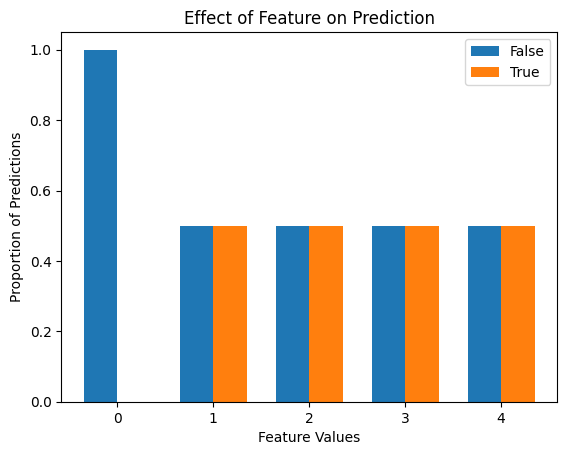

In [39]:
x_archetype_test = archetype_test_data.copy(deep=True).astype(np.float32)
m1_pred = model_1.run(None, {'X': x_archetype_test.values.astype(np.float32)})[0]
m2_pred = model_2.run(None, {'X': x_archetype_test.values.astype(np.float32)})[0]

feature_name = 'relatie_kind_huidige_aantal'
feature_values = archetype_test_data[feature_name].tolist()

unique_values = list(set(feature_values))
unique_values.sort()  # Sort for consistency in plotting

# Calculate the proportion of predictions (0 and 1) for each unique feature value
proportions_0 = []
proportions_1 = []
for value in unique_values:
    count_0 = sum(1 for i, val in enumerate(feature_values) if val == value and m2_pred[i] == 0)
    count_1 = sum(1 for i, val in enumerate(feature_values) if val == value and m2_pred[i] == 1)
    total_count = count_0 + count_1
    proportions_0.append(count_0 / total_count if total_count != 0 else 0)
    proportions_1.append(count_1 / total_count if total_count != 0 else 0)

# Plot the proportions
x = np.arange(len(unique_values))
width = 0.35
fig, ax = plt.subplots()
bars_0 = ax.bar(x - width/2, proportions_0, width, label='False')
bars_1 = ax.bar(x + width/2, proportions_1, width, label='True')

# Add labels, title, and legend
ax.set_xlabel('Feature Values')
ax.set_ylabel('Proportion of Predictions')
ax.set_title('Effect of Feature on Prediction')
ax.set_xticks(x)
ax.set_xticklabels(unique_values)
ax.legend()

plt.show()

In [20]:
y_archetype_test_zeros = pd.DataFrame(np.zeros(1250), columns=['checked'])
X_archetype_test_zeros = archetype_test_data.copy(deep=True).astype(np.float32)

y_archetype_test_ones = pd.DataFrame(np.ones(1250), columns=['checked'])
X_archetype_test_ones = archetype_test_data.copy(deep=True).astype(np.float32)

y_archetype_test_random = pd.DataFrame(np.random.randint(2,size=1250), columns=['checked'])
X_archetype_test_random = archetype_test_data.copy(deep=True).astype(np.float32)

In [ ]:
y_pred_m1_zeros =  model_1.run(None, {'X': X_archetype_test_zeros.values.astype(np.float32)})
y_pred_m1_ones =  model_1.run(None, {'X': X_archetype_test_ones.values.astype(np.float32)})
y_pred_m1_random =  model_1.run(None, {'X': X_archetype_test_random.values.astype(np.float32)})

evaluate_m1_zeros = evaluate(y_archetype_test_zeros, y_pred_m1_zeros[0])
evaluate_m1_ones = evaluate(y_archetype_test_ones, y_pred_m1_ones[0])
evaluate_m1_random = evaluate(y_archetype_test_random, y_pred_m1_random[0])
print('Evaluation of m1 on test zeros: ', evaluate_m1_zeros)
print('Evaluation of m1 on test ones: ', evaluate_m1_ones)
print('Evaluation of m1 on test random: ', evaluate_m1_random)

Evaluation of m1 on test zeros:  (1.0, 0.0, 0.0, 0.0)
Evaluation of m1 on test ones:  (0.0, 0.0, 0.0, 0.0)
Evaluation of m1 on test random:  (0.512, 0.0, 0.0, 0.0)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precis

In [ ]:
y_pred_m2_zeros =  model_2.run(None, {'X': X_archetype_test_zeros.values.astype(np.float32)})
y_pred_m2_ones =  model_2.run(None, {'X': X_archetype_test_ones.values.astype(np.float32)})
y_pred_m2_random =  model_2.run(None, {'X': X_archetype_test_random.values.astype(np.float32)})

evaluate_m2_zeros = evaluate(y_archetype_test_zeros, y_pred_m2_zeros[0])
evaluate_m2_ones = evaluate(y_archetype_test_ones, y_pred_m2_ones[0])
evaluate_m2_random = evaluate(y_archetype_test_random, y_pred_m2_random[0])
print('Evaluation of m2 on test: ', evaluate_m2_zeros)
print('Evaluation of m2 on test: ', evaluate_m2_ones)
print('Evaluation of m2 on test: ', evaluate_m2_random)

Evaluation of m2 on test:  (0.6, 0.0, 0.0, 0.0)
Evaluation of m2 on test:  (0.4, 1.0, 0.4, 0.5714285714285715)
Evaluation of m2 on test:  (0.4976, 0.482, 0.3950819672131147, 0.43423423423423424)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_pred_m_gbc_zeros =  model_gbc.run(None, {'X': X_archetype_test_zeros.values.astype(np.float32)})
y_pred_m_gbc_ones =  model_gbc.run(None, {'X': X_archetype_test_ones.values.astype(np.float32)})
y_pred_m_gbc_random =  model_gbc.run(None, {'X': X_archetype_test_random.values.astype(np.float32)})

evaluate_m_gbc_zeros = evaluate(y_archetype_test_zeros, y_pred_m_gbc_zeros[0])
evaluate_m_gbc_ones = evaluate(y_archetype_test_ones, y_pred_m_gbc_ones[0])
evaluate_m_gbc_random = evaluate(y_archetype_test_random, y_pred_m_gbc_random[0])
print('Evaluation of m_gbc on test: ', accuracy_m_gbc_zeros)
print('Evaluation of m_gbc on test: ', accuracy_m_gbc_ones)
print('Evaluation of m_gbc on test: ', accuracy_m_gbc_random)

Evaluation of m_gbc on test:  0.0
Evaluation of m_gbc on test:  1.0
Evaluation of m_gbc on test:  0.4928


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Confusion Matrix

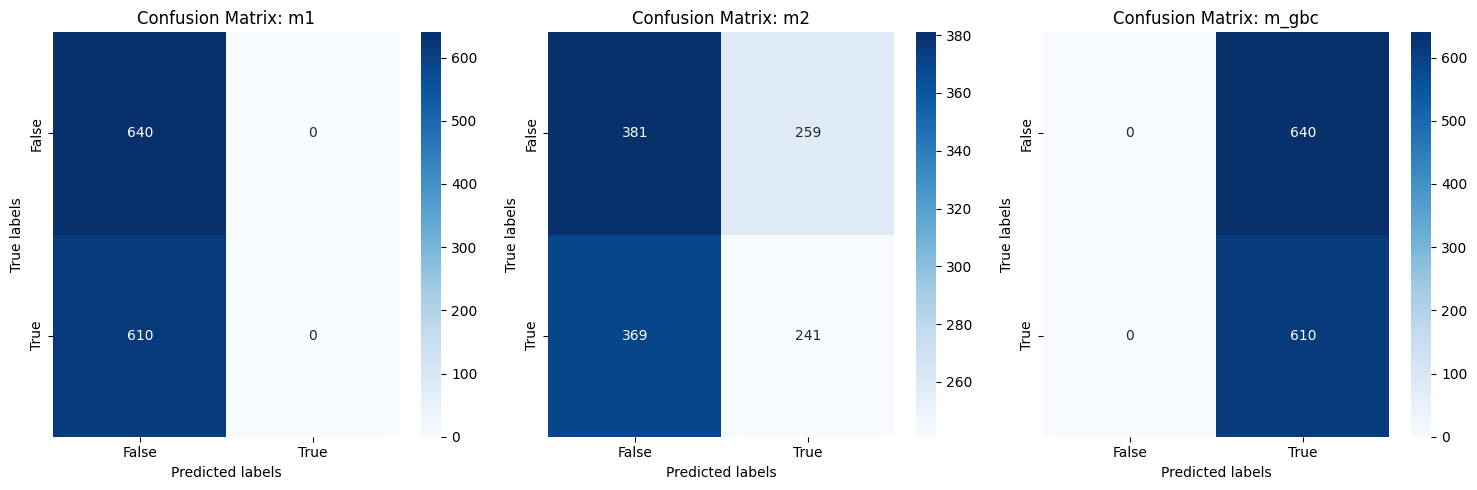

In [ ]:
m1_confusion_matrix_zeros = confusion_matrix(y_archetype_test_zeros, y_pred_m1_zeros[0])
m2_confusion_matrix_zeros = confusion_matrix(y_archetype_test_zeros, y_pred_m2_zeros[0])
m_gbc_confusion_matrix_zeros = confusion_matrix(y_archetype_test_zeros, y_pred_m_gbc_zeros[0])
m1_confusion_matrix_ones = confusion_matrix(y_archetype_test_ones, y_pred_m1_ones[0])
m2_confusion_matrix_ones = confusion_matrix(y_archetype_test_ones, y_pred_m2_ones[0])
m_gbc_confusion_matrix_ones = confusion_matrix(y_archetype_test_ones, y_pred_m_gbc_ones[0])
m1_confusion_matrix_random = confusion_matrix(y_archetype_test_random, y_pred_m1_random[0])
m2_confusion_matrix_random = confusion_matrix(y_archetype_test_random, y_pred_m2_random[0])
m_gbc_confusion_matrix_random = confusion_matrix(y_archetype_test_random, y_pred_m_gbc_random[0])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot_confusion_matrix(m1_confusion_matrix_random, "m1", ax[0])
plot_confusion_matrix(m2_confusion_matrix_random, "m2", ax[1])
plot_confusion_matrix(m_gbc_confusion_matrix_random, "m_gbc", ax[2])

# plot_confusion_matrix(m1_confusion_matrix_ones, "m1", ax[0])
# plot_confusion_matrix(m2_confusion_matrix_ones, "m2", ax[1])
# plot_confusion_matrix(m_gbc_confusion_matrix_ones, "m_gbc", ax[2])


plt.tight_layout()
plt.show()

In [100]:
# pred_dif = {}
# pred_to_y_dist  = {}
# pred_to_y_cat= {}

def feature_effect(model, data, feature: str, feature_type: str, values=None, dicts=None):

  if feature not in data.columns:
    raise ValueError(f"The feature '{feature}' is not found in the data.")


  if feature_type == 'numeric':
    predictions1, predictions2 = [], []
    start, end = values[0], values[1]
    test_data =data.copy(deep=True)
    test_data[feature] = start
    predictions1 =  model_1.run(None, {'X': test_data.values.astype(np.float32)})[0]
    test_data[feature] = end
    predictions2 = model.run(None, {'X': test_data.values.astype(np.float32)})[0]
    dicts[0][(feature, start, sum(abs(predictions1 - y_test_data_from_training)) , end, sum(abs(predictions2 - y_test_data_from_training)))] = abs(sum(abs(predictions1 - y_test_data_from_training)) - sum(abs(predictions2 - y_test_data_from_training)))
    # dicts[0][(feature, end, 'max')] = sum(abs(predictions2 - y_test_data_from_training))
    dicts[1][feature] = sum(abs(predictions1 - predictions2)) / len(predictions1)



In [17]:
feature_importances = pd.read_csv('/content/drive/MyDrive/tnv-final-project/features.csv', encoding='latin-1')

In [92]:
sorted_features = feature_importances.sort_values(by='relative_importance', ascending=False)
numeric_features = [feature for feature, dtype in zip(sorted_features['feature'], sorted_features['datatype']) if dtype in ('int', 'float')]

In [99]:
m1_pred_dif = {}
m1_pred_to_y_dist  = {}
m1_pred_to_y_cat= {}

m2_pred_dif = {}
m2_pred_to_y_dist  = {}
m2_pred_to_y_cat= {}

for val in tqdm(numeric_features):
  max = X_test_data_from_training[val].max()
  min = X_test_data_from_training[val].min()
  feature_effect(model_1, X_test_data_from_training, val, 'numeric', values = (min, max), dicts = (m1_pred_dif ,m1_pred_to_y_dist, m1_pred_to_y_cat))
  feature_effect(model_2, X_test_data_from_training, val, 'numeric', values = (min, max), dicts = (m2_pred_dif, m2_pred_to_y_dist, m2_pred_to_y_cat))



100%|██████████| 315/315 [00:14<00:00, 22.06it/s]


In [103]:
counter = 0
# print(len(m2_pred_y_to_dist))
for v in m2_pred_to_y_dist.values():
  # if v > 0.05:
  counter += 1
  # else:
  #   print(v)
print(counter)

315


# Values Distribution

In [101]:
print({k: v for k, v in sorted(m1_pred_dif.items(), key=lambda item: item[1], reverse = True)})
print({k: v for k, v in sorted(m2_pred_dif.items(), key=lambda item: item[1], reverse = True)})

print({k: v for k, v in sorted(m1_pred_to_y_dist.items(), key=lambda item: item[1], reverse = True)})
print({k: v for k, v in sorted(m2_pred_to_y_dist.items(), key=lambda item: item[1], reverse = True)})

# print({k: v for k, v in sorted(pred_to_y_cat.items(), key=lambda item: item[1], reverse = True)})

{('persoon_leeftijd_bij_onderzoek', 19.0, 351, 67.0, 306): 45, ('relatie_overig_historie_vorm__andere_inwonende', 0.0, 306, 3.0, 309): 3, ('adres_dagen_op_adres', 3.0, 308, 24316.0, 306): 2, ('afspraak_signaal_voor_medewerker', 0.0, 308, 17.0, 307): 1, ('contacten_onderwerp_documenttype__cv_', 0.0, 308, 5.0, 307): 1, ('relatie_overig_actueel_vorm__kostendeler', 0.0, 308, 4.0, 308): 0, ('contacten_onderwerp_no_show', 0.0, 308, 5.0, 308): 0, ('competentie_vakdeskundigheid_toepassen', 0.0, 308, 3.0, 308): 0, ('contacten_onderwerp_overleg_met_inkomen', 0.0, 308, 5.0, 308): 0, ('relatie_overig_kostendeler', 0.0, 308, 1.0, 308): 0, ('pla_historie_ontwikkeling', 0.0, 308, 1.0, 308): 0, ('instrument_ladder_huidig_activering', 0.0, 308, 3.0, 308): 0, ('contacten_soort_afgelopenjaar_document__uitgaand_', 0.0, 308, 26.0, 308): 0, ('persoonlijke_eigenschappen_dagen_sinds_taaleis', 0.0, 308, 1710.0, 308): 0, ('persoonlijke_eigenschappen_dagen_sinds_opvoer', 0.0, 308, 2373.0, 308): 0, ('ontheffing_d

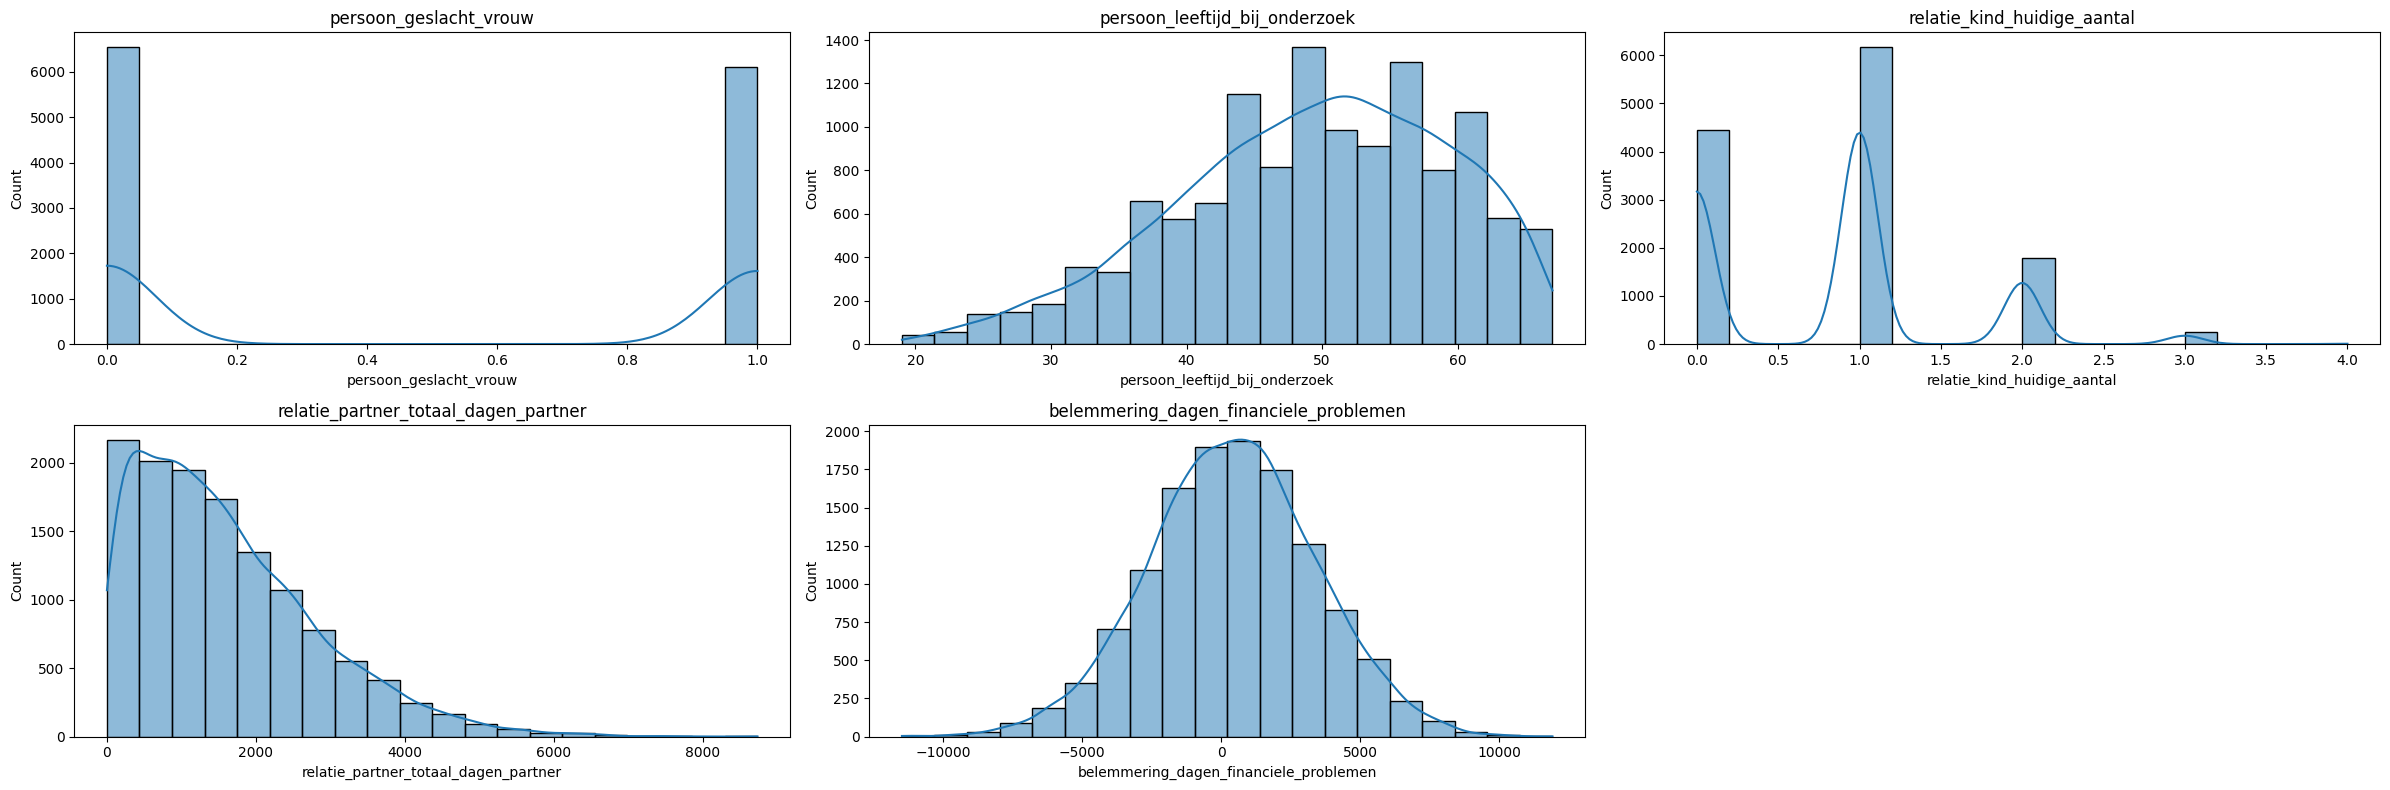

In [90]:
critical_features = ['persoon_geslacht_vrouw',
                     'persoon_leeftijd_bij_onderzoek',
                     'relatie_kind_huidige_aantal',
                     'relatie_partner_totaal_dagen_partner',
                     'belemmering_dagen_financiele_problemen'
                    ]

# features_to_plot = critical_features + list(og_data.columns.difference(critical_features))
features_to_plot = critical_features


n_features = len(features_to_plot)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

plt.figure(figsize=(24, 4 * n_rows))

for i, feature in enumerate(features_to_plot, 1):
  plt.subplot(n_rows, n_cols, i)
  sns.histplot(og_data[feature], kde=True, bins=20)
  plt.title(feature)

plt.tight_layout()
plt.show()

#